## Projeto de Clusterização de Clientes (Setor de Energia Elétrica)

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [130]:
df_original = pd.read_csv('Dados/consumo_energia.txt', delimiter = ';')

In [131]:
df_original.shape

(2075259, 9)

In [132]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [133]:
df_original.isnull().values.any()

True

In [134]:
df_original.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [135]:
display(df_original.duplicated().sum())

0

In [136]:
# Removendo os valores NA e as colunas desnecessárias (cols 1 e 2)
df_original = df_original.iloc[0:, 2:9].dropna()

In [137]:
df_original.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


O Dataset é um pouco grande, para não precisarmos reparti-lo, vamos tentar trabalhar com um formato mais leve. (CSV -> Parquet)

In [138]:
#!pip install pyarrow
#!pip install fastparquet

In [139]:
# Convertendo as colunas para os tipos de dados adequados
df_original['Voltage'] = df_original['Voltage'].astype(dtype = 'float64')
df_original['Global_active_power'] = df_original['Global_active_power'].astype(dtype = 'float64')
df_original['Global_reactive_power'] = df_original['Global_reactive_power'].astype(dtype = 'float64')
df_original['Global_intensity'] = df_original['Global_intensity'].astype(dtype = 'float64')
df_original['Sub_metering_1'] = df_original['Sub_metering_1'].astype(dtype = 'float64')
df_original['Sub_metering_2'] = df_original['Sub_metering_2'].astype(dtype = 'float64')
df_original['Sub_metering_3'] = df_original['Sub_metering_3'].astype(dtype = 'float64')

# Salvar o DataFrame em formato Parquet
df_original.to_parquet('Dados/consumo_energia.parquet', index=False)

# Carregar o DataFrame a partir do arquivo Parquet
df = pd.read_parquet('Dados/consumo_energia.parquet')

# Verificar se os dados foram carregados corretamente
display(df.head())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 109.4 MB


In [141]:
df.isnull().values.any()

False

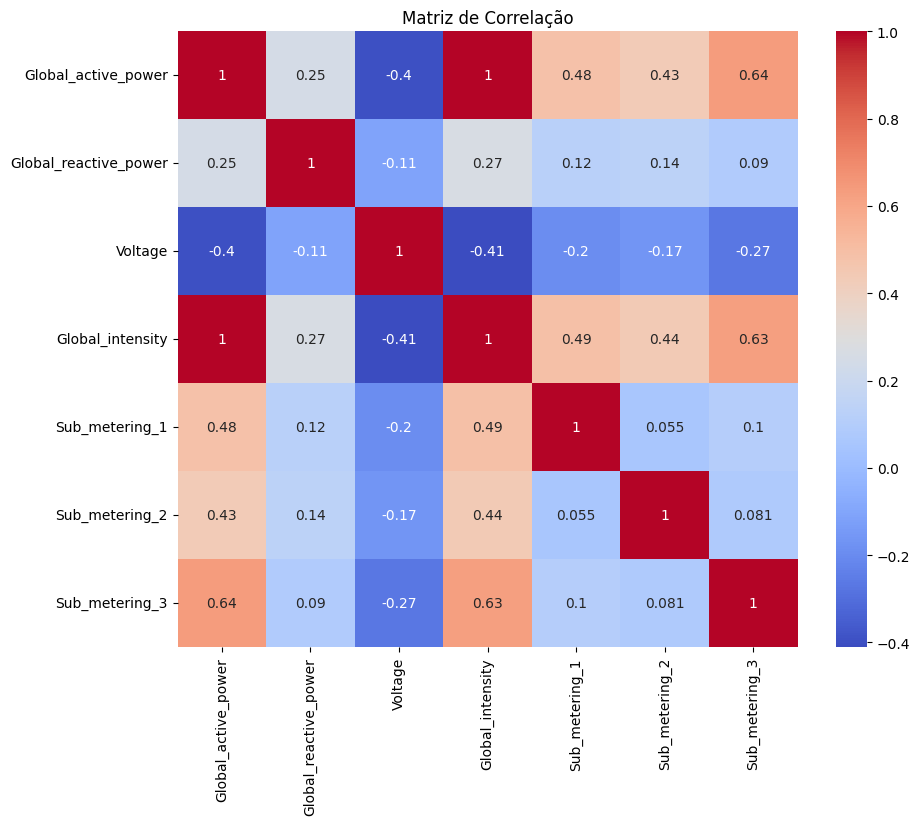

In [142]:
# Identificar correlações entre as variáveis
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Clusterização

In [143]:
# Obtém os valores dos atributos.
df_val = df.values

In [144]:
df_val

array([[  4.216,   0.418, 234.84 , ...,   0.   ,   1.   ,  17.   ],
       [  5.36 ,   0.436, 233.63 , ...,   0.   ,   1.   ,  16.   ],
       [  5.374,   0.498, 233.29 , ...,   0.   ,   2.   ,  17.   ],
       ...,
       [  0.938,   0.   , 239.82 , ...,   0.   ,   0.   ,   0.   ],
       [  0.934,   0.   , 239.7  , ...,   0.   ,   0.   ,   0.   ],
       [  0.932,   0.   , 239.55 , ...,   0.   ,   0.   ,   0.   ]])

In [145]:
# Cria o objeto para normalizar e faz a normalizacao dos dados
#Padronizador = MinMaxScaler()
#df_val = Padronizador.fit_transform(df_val)

In [146]:
# Coleta uma amostra de 2% dos dados para aplicar o K-Means sem pesar muito
amostra1, amostra2 = train_test_split(df_val, train_size = .02)

In [147]:
amostra1.shape

(40985, 7)

In [148]:
# Aplica redução de dimensionalidade de 7 var para 2 var utilizando Algebra Linear
pca = PCA(n_components = 2).fit_transform(amostra1)

In [149]:
# Determinando um range de K
k_range = range(1,12)

In [150]:
# Criando uma lista com os modelos K-Means treinados para cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [151]:
# Criando uma lista com os centros cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [152]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [153]:
# Criando uma lista contendo a soma dos quadrados das distâncias intra-cluster 
# para cada modelo KMeans treinado.
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [154]:
# Soma total dos quadrados. Valores menores indicam que os pontos dentro de 
# cada cluster estão mais próximos entre si
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [155]:
# Soma dos quadrados entre clusters. 
# Entendendo dispersão dos clusters em relação à dispersão total dos dados.
# Valores menores indicam que os pontos dentro de cada cluster são mais distantes.
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

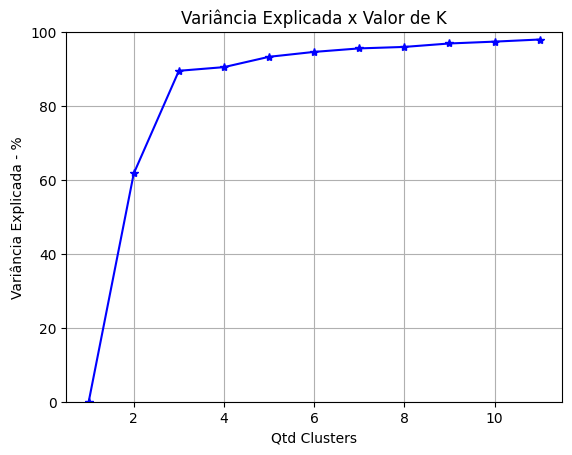

In [156]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Qtd Clusters')
plt.ylabel('Variância Explicada - %')
plt.title('Variância Explicada x Valor de K')

In [157]:
# Criando um modelo com K = 10
modelo_v1 = KMeans(n_clusters = 7)
modelo_v1.fit(pca)

KMeans(n_clusters=7)

In [158]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

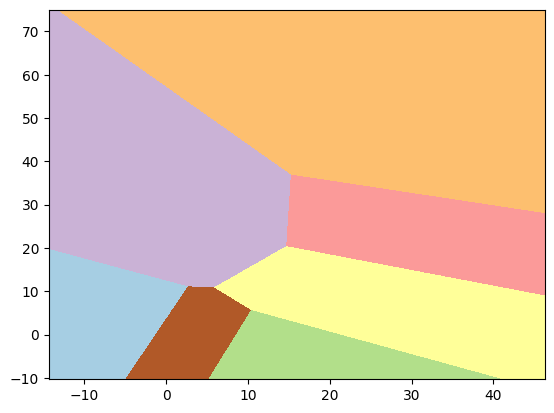

In [159]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

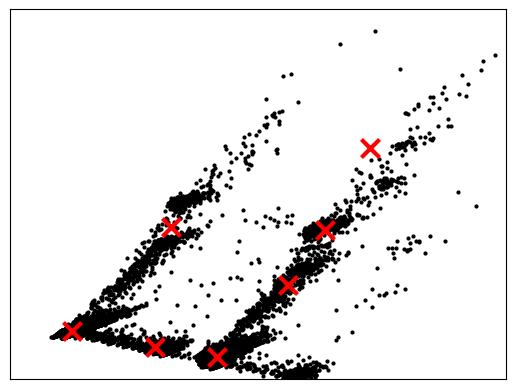

In [160]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [161]:
# Utilizando Silhouette Score para calcular o escore de silhueta para avaliar
# a qualidade dos clusters produzidos pelo modelo KMeans treinado.
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.7887346053172282